<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/samplingDesign/CACTITomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Simple CACTI coding example
##David Brady
##University of Arizona
##November 2023


Here we consider coding strategies for reconstruction of a signal of one spatial dimension and time $f(x,t)$. We assume a vector of 1D measurements taken in a snapshot
$$
g(x)=\int f(x,t)h(x,t) dt
$$
Examples include stroboscopic imaging, which which case $h(t)$ is a sequence of pulses and moving coded aperture imaging, in which case $h(x)$ is a random code and
$$
g(x)=\int f(x,t)h(x-vt) dt
$$
and random coded illumination, in which case $h(x,t)$ is a random sequence of spatial codes.

We use the estimation strategy developed for tomographic imaging in Section 4.4 of **Computational Imaging**

### Python modules

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist


## Forward Models

As in chapter 4, we seek to reconstruct the MNIST data set from compressive measurements. The MIST images are 28 by 28 pixels. In the present case, we seek to reconstruct from a single vector of 28 measurements integrated along the horizontal axis. We use random binary codes for our measurement matrices. For the first instance the code is a 28 element random sequence and
$$
h_{ij}=p[j]
$$
This corresponds to strobing the planes of the data cube. In the second case,
$$
h_{ij}=p[i-j]
$$
This corresponds to shifting the code diagonally across the measurement plane.
In the final case $h_{ij}$ is itself a random binary value.
Measurements take the form
$$
g_i=\sum_j h_{ij}f_{ij}
$$


### example sampling matrices

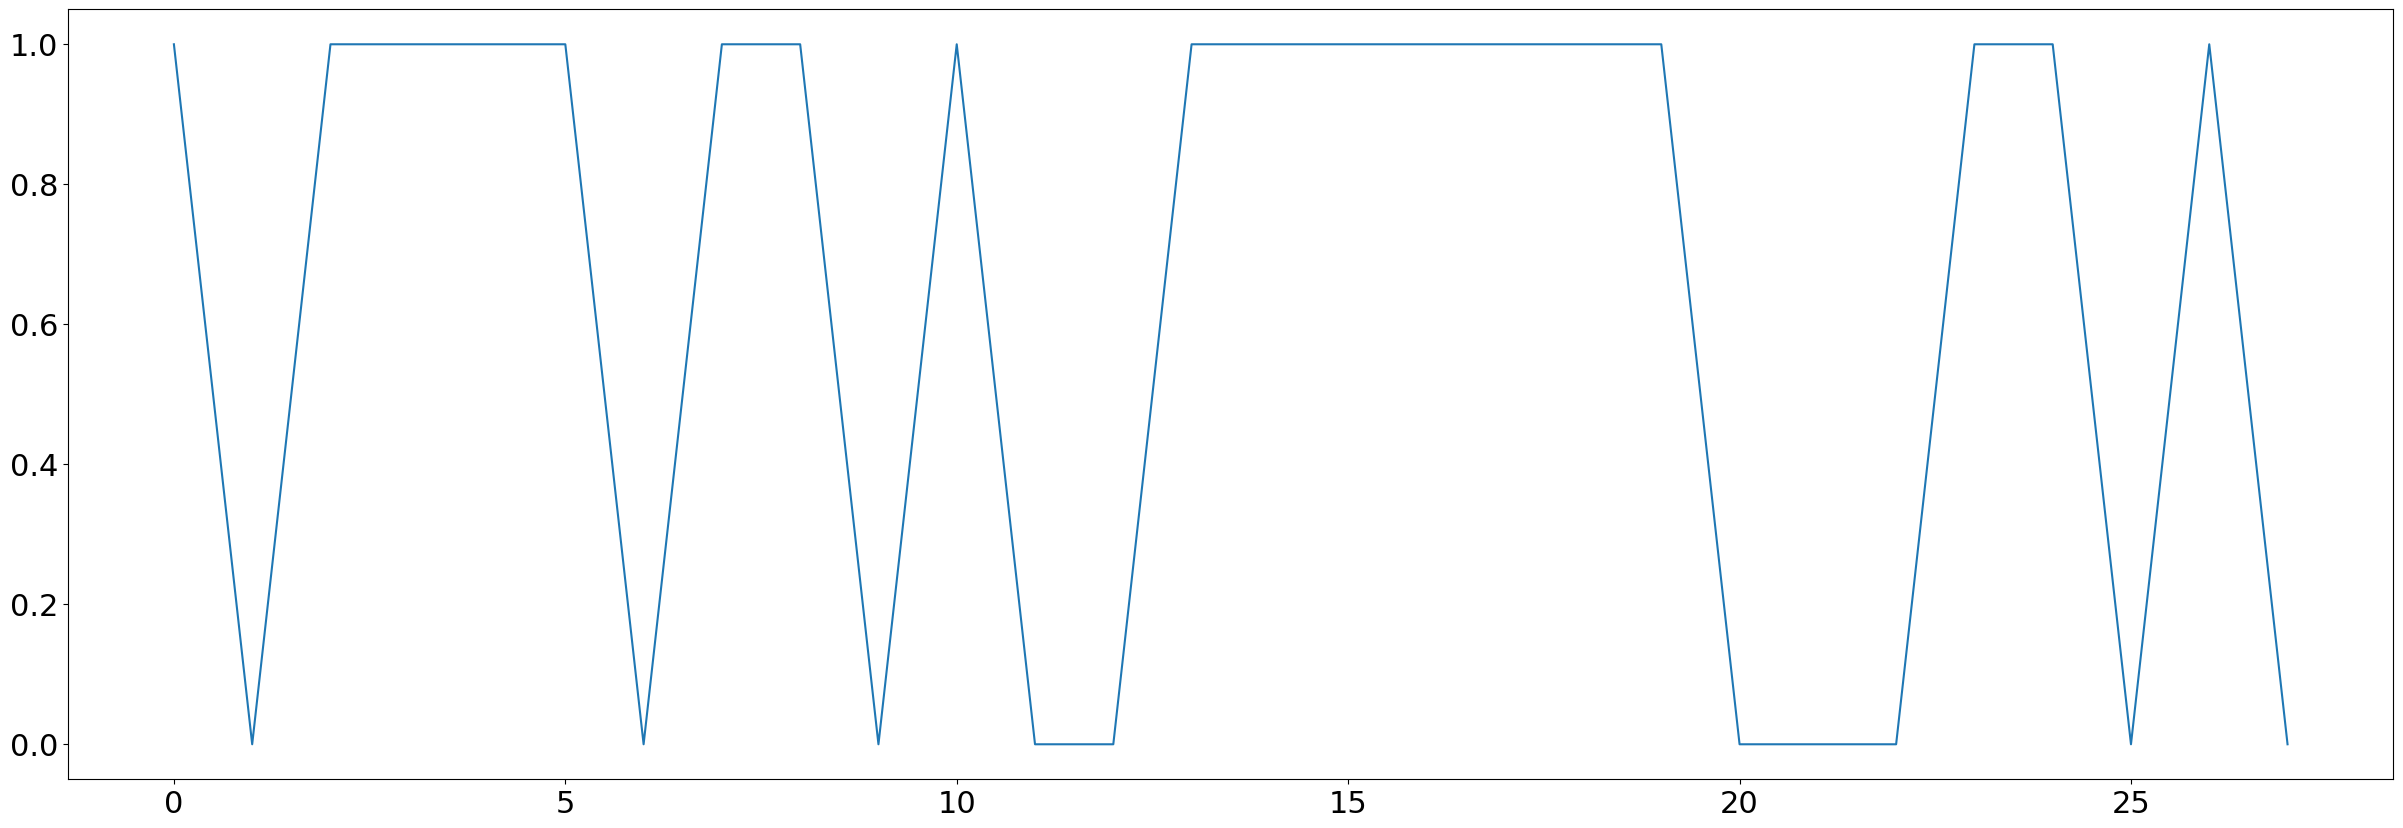

In [2]:
N=28
p=np.random.randint(0,2,28)
plt.plot(p)

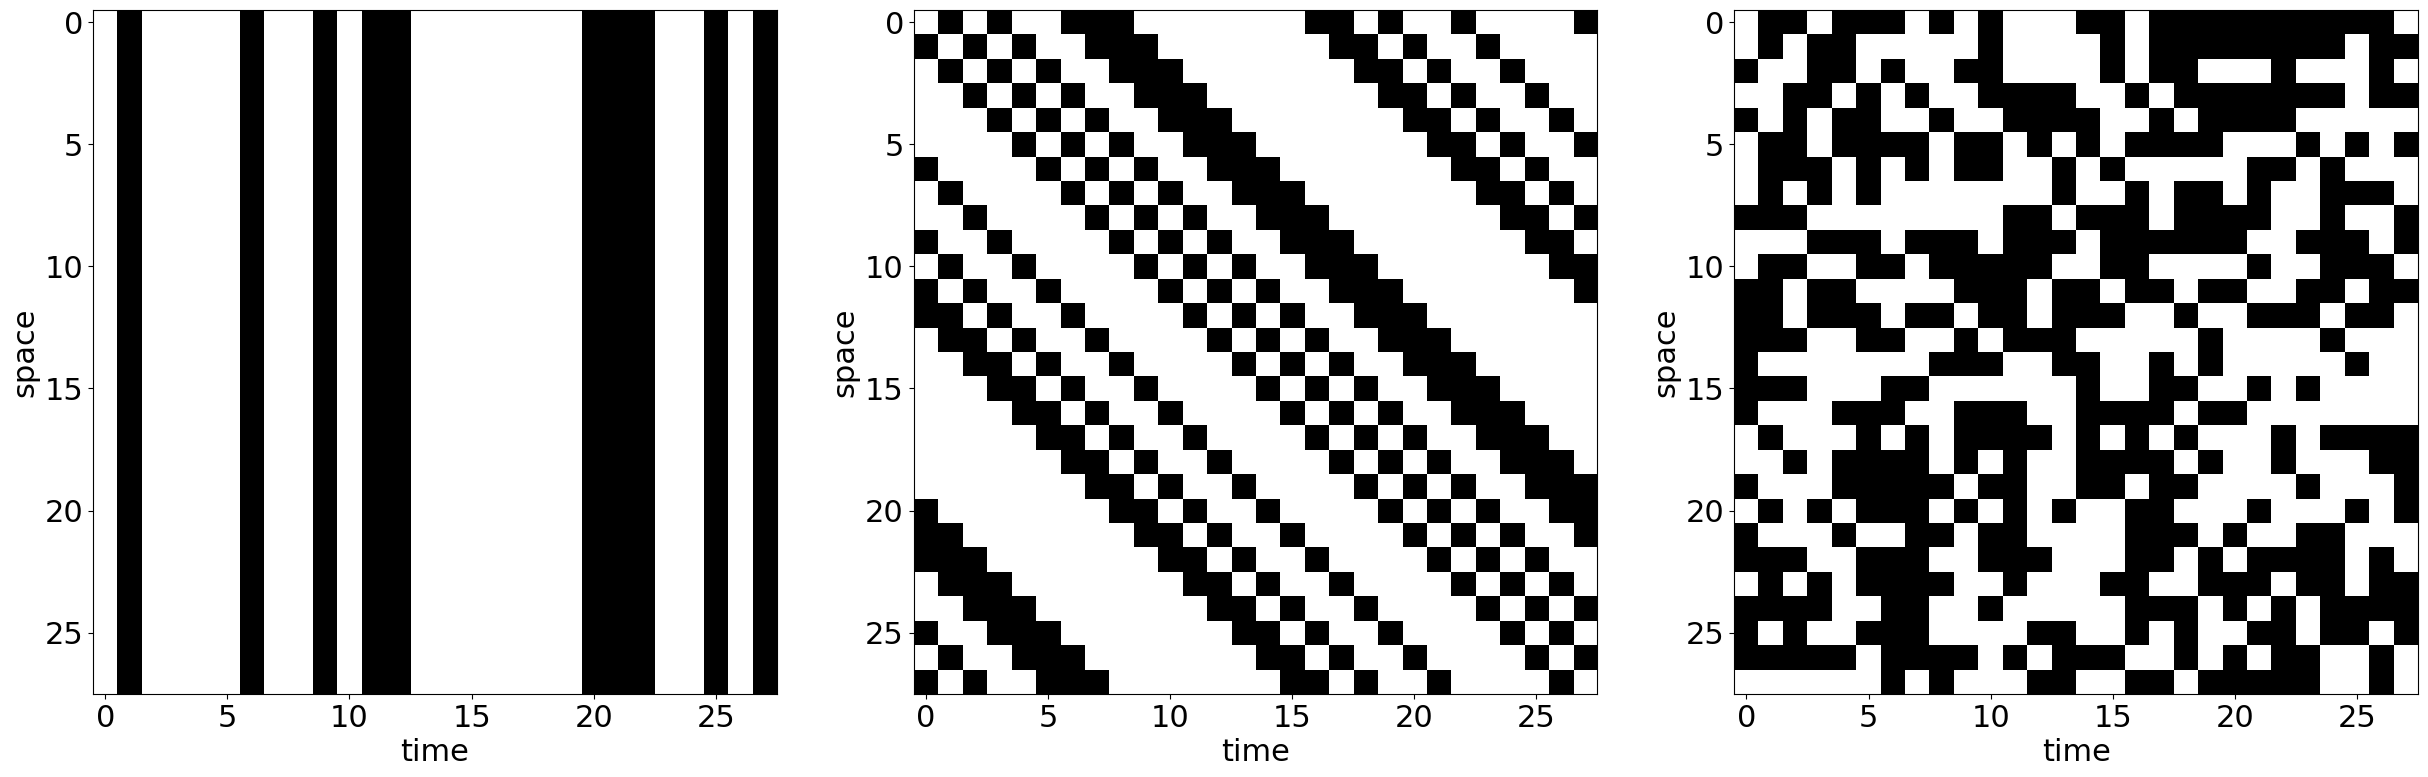

In [131]:
h1=np.zeros((N,N))
h2=np.zeros((N,N))
h3=np.random.randint(0,2,(N,N))
H1=np.zeros((N,N**2))
H2=np.zeros((N,N**2))
H3=np.zeros((N,N**2))
for pop in range(N):
  h1[:,pop]=p[pop]
  h2[:,pop]=np.roll(p,pop)
  H1[pop,(pop*N):((pop+1)*N)]=h1[:,pop]
  H2[pop,(pop*N):((pop+1)*N)]=h2[:,pop]
  H3[pop,(pop*N):((pop+1)*N)]=h3[:,pop]
plt.subplot(1,3,1)
plt.imshow(h1, cmap='gray')
plt.xlabel('time')
plt.ylabel('space')
plt.subplot(1,3,2)
plt.imshow(h2,cmap='gray')
plt.xlabel('time')
plt.ylabel('space')
plt.subplot(1,3,3)
plt.imshow(h3, cmap='gray')
plt.xlabel('time')
plt.ylabel('space')
plt.savefig('cactiSampling.pdf')


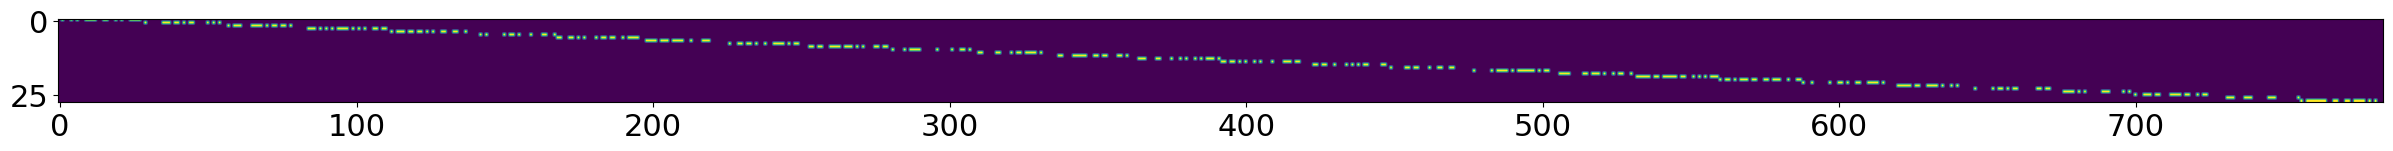

In [16]:
plt.imshow(H3)

# Neural Estimation

## Image database

In [78]:
# load the mnist dataset of characters


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
x_trainN = np.reshape(x_train, (len(x_train), N, N, 1))
x_testN = np.reshape(x_test, (len(x_test), N, N, 1))

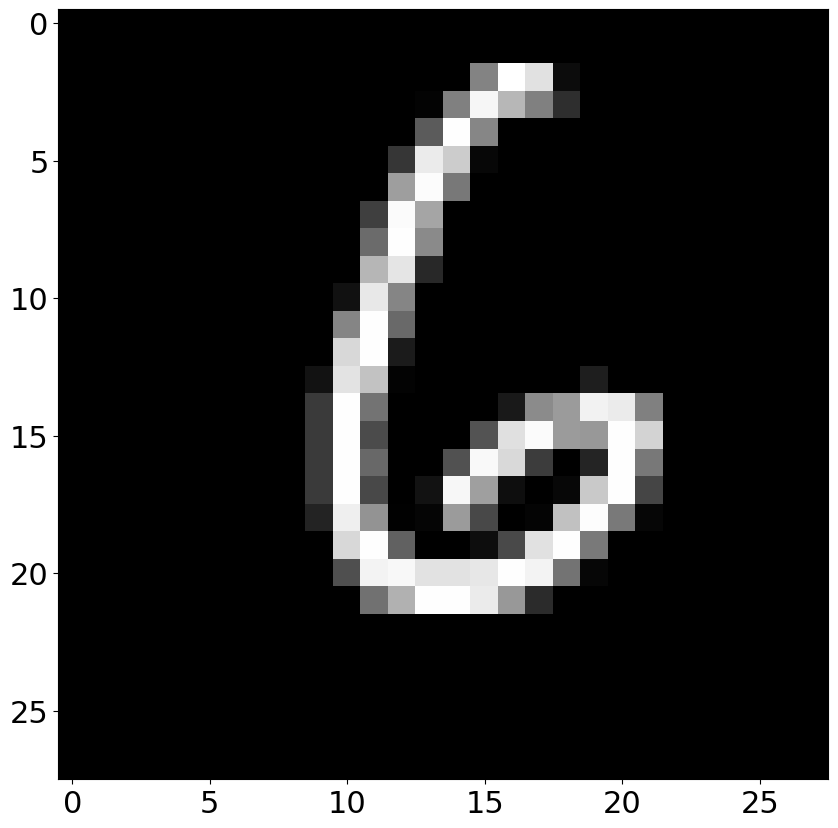

In [79]:
plt.imshow(x_train[32],cmap='gray')

## Random illumination codes

###  prepare training data

In [138]:


g_test=np.zeros((x_test.shape[0],N))
g_train=np.zeros((x_train.shape[0],N))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:]= np.matmul(H3,np.reshape(x_test[pop],N**2))
  g_test[pop,:]=g_test[pop,:]/np.max(g_test[pop,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:]=np.matmul(H3,np.reshape(x_train[pop],N**2))
  g_train[pop,:]=g_train[pop,:]/np.max(g_train[pop,:])
g_train = np.reshape(g_train, (len(g_train), N))
g_test = np.reshape(g_test, (len(g_test), N))

### Encoder/denoising model

In [139]:
inputs=keras.Input(shape=(N))
# Transformer
x =layers.Dense(N**2,activation="gelu")(inputs)
x = layers.Reshape((N,N,-1))(x)

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2D(32, (4, 4), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="gelu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

randomCodes = keras.Model(inputs, x)
randomCodes.compile(optimizer='adam', loss='mean_squared_error')
randomCodes.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28)]              0         
                                                                 
 dense_20 (Dense)            (None, 784)               22736     
                                                                 
 reshape_20 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 32)        16416     
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_transpose_97 (Conv2  (None, 14, 14, 64)        369

### Training

In [140]:
randomCodes.fit(
    x=g_train,
    y=x_trainN,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_testN),
)

Epoch 1/30
469/469 [==============================] - 6s 8ms/step - loss: 0.0492 - val_loss: 0.0369
Epoch 2/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0351 - val_loss: 0.0330
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0316 - val_loss: 0.0300
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0294 - val_loss: 0.0284
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0279 - val_loss: 0.0272
Epoch 6/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0269 - val_loss: 0.0262
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0261 - val_loss: 0.0255
Epoch 8/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0255 - val_loss: 0.0250
Epoch 9/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0249 - val_loss: 0.0247
Epoch 10/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0245 - val_loss: 0.0243

### Example estimated images



1/1 [==============================] - 0s 20ms/step


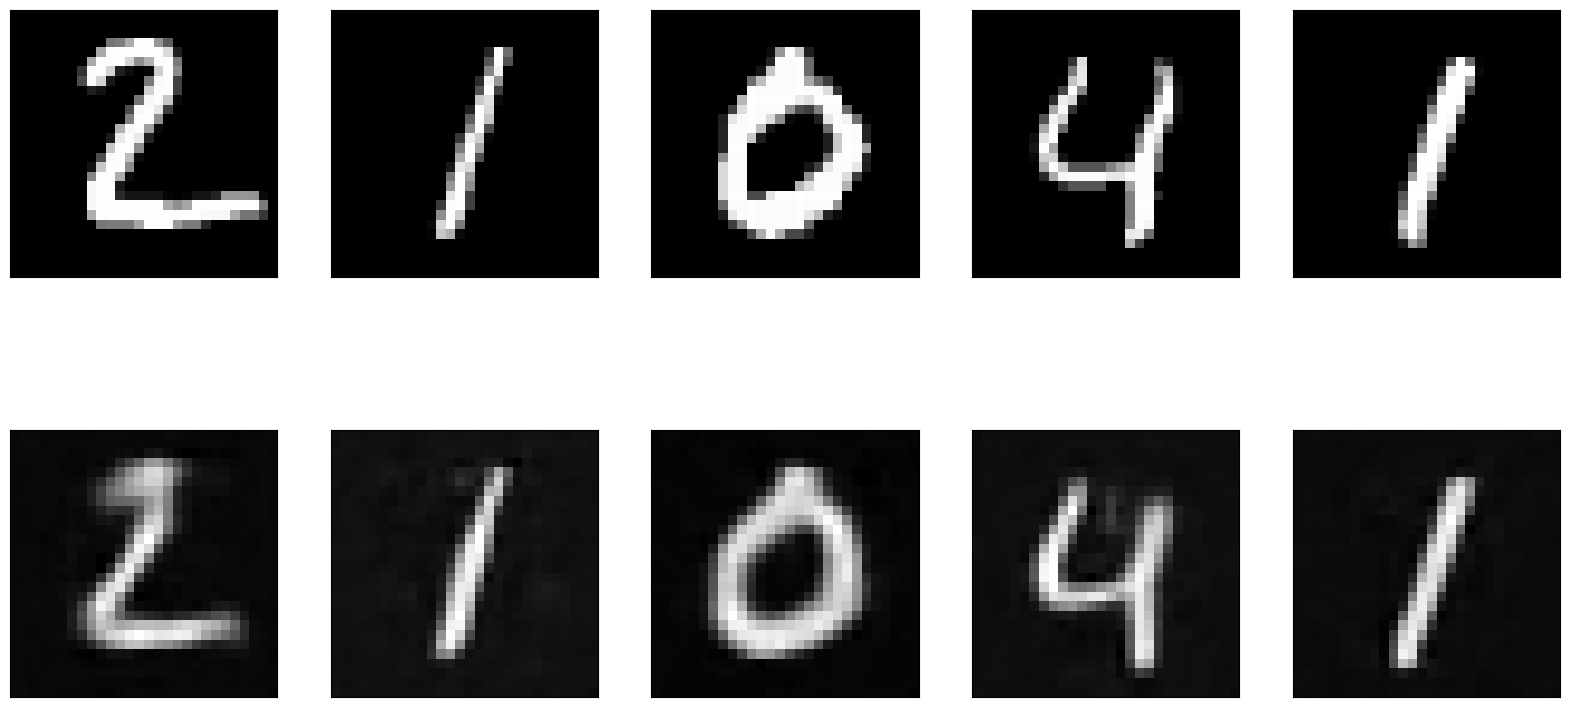

In [141]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(randomCodes.predict(g_test[i:(i+1),:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


## CACTI illumination codes

###  prepare training data

In [87]:
g_test=np.zeros((x_test.shape[0],N))
g_train=np.zeros((x_train.shape[0],N))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:]= np.matmul(H2,np.reshape(x_test[pop],N**2))
  g_test[pop,:]=g_test[pop,:]/np.max(g_test[pop,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:]=np.matmul(H2,np.reshape(x_train[pop],N**2))
  g_train[pop,:]=g_train[pop,:]/np.max(g_train[pop,:])
g_train = np.reshape(g_train, (len(g_train), N))
g_test = np.reshape(g_test, (len(g_test), N))

### Encoder/denoising model

In [88]:
inputs=keras.Input(shape=(N))




# Transformer
x =layers.Dense(N**2,activation="gelu")(inputs)
x = layers.Reshape((N,N,-1))(x)

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

cactiCodes = keras.Model(inputs, x)
cactiCodes.compile(optimizer='adam', loss='mean_squared_error')
cactiCodes.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 28)]              0         
                                                                 
 dense_18 (Dense)            (None, 784)               22736     
                                                                 
 reshape_18 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 32)        16416     
                                                                 
 conv2d_38 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_transpose_87 (Conv2  (None, 14, 14, 64)        369

In [34]:
inputs.shape

TensorShape([None, 28, 1])

### Training

In [89]:
cactiCodes.fit(
    x=g_train,
    y=x_trainN,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_testN),
)

Epoch 1/30
469/469 [==============================] - 6s 7ms/step - loss: 0.0530 - val_loss: 0.0425
Epoch 2/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0401 - val_loss: 0.0384
Epoch 3/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0373 - val_loss: 0.0363
Epoch 4/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0357 - val_loss: 0.0353
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0346 - val_loss: 0.0342
Epoch 6/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0338 - val_loss: 0.0337
Epoch 7/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 8/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0328 - val_loss: 0.0325
Epoch 9/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0322 - val_loss: 0.0322
Epoch 10/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0319 - val_loss: 0.0323

### Example estimated images

1/1 [==============================] - 0s 19ms/step


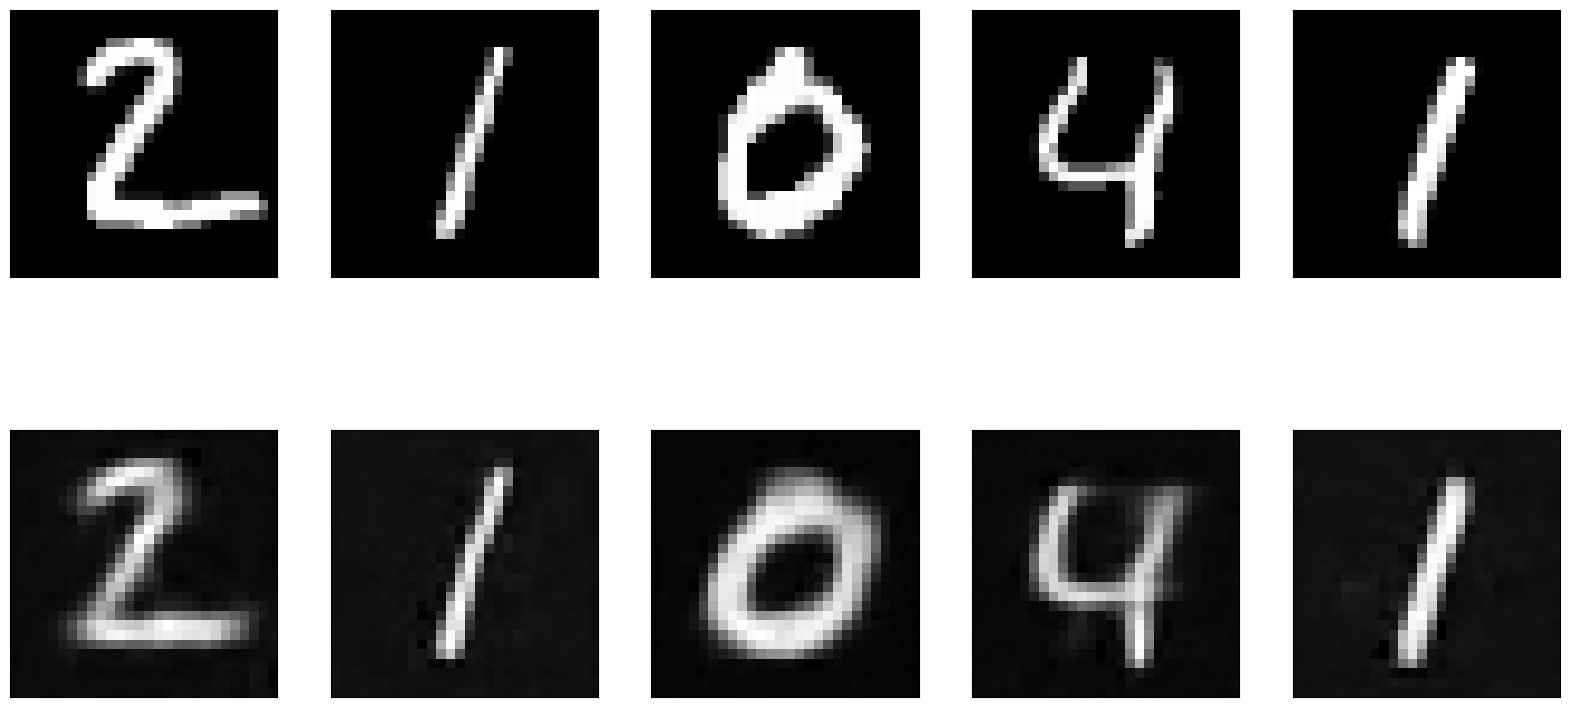

In [90]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(cactiCodes.predict(g_test[i:(i+1),:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



## Flutter illumination codes

###  prepare training data

In [91]:


g_test=np.zeros((x_test.shape[0],N))
g_train=np.zeros((x_train.shape[0],N))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:]= np.matmul(H1,np.reshape(x_test[pop],N**2))
  g_test[pop,:]=g_test[pop,:]/np.max(g_test[pop,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:]=np.matmul(H1,np.reshape(x_train[pop],N**2))
  g_train[pop,:]=g_train[pop,:]/np.max(g_train[pop,:])
g_train = np.reshape(g_train, (len(g_train), N))
g_test = np.reshape(g_test, (len(g_test), N))

### Encoder/denoising model

In [92]:
inputs=keras.Input(shape=(N))




# Transformer
x =layers.Dense(N**2,activation="gelu")(inputs)
x = layers.Reshape((N,N,-1))(x)

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

flutterCodes = keras.Model(inputs, x)
flutterCodes.compile(optimizer='adam', loss='mean_squared_error')
flutterCodes.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 28)]              0         
                                                                 
 dense_19 (Dense)            (None, 784)               22736     
                                                                 
 reshape_19 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_40 (Conv2D)          (None, 14, 14, 32)        16416     
                                                                 
 conv2d_41 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_transpose_92 (Conv2  (None, 14, 14, 64)        369

In [93]:
flutterCodes.fit(
    x=g_train,
    y=x_trainN,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_testN),
)

Epoch 1/30
469/469 [==============================] - 6s 7ms/step - loss: 0.0576 - val_loss: 0.0505
Epoch 2/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0495 - val_loss: 0.0482
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0480 - val_loss: 0.0474
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0472 - val_loss: 0.0468
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0465 - val_loss: 0.0460
Epoch 6/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0461 - val_loss: 0.0458
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0458 - val_loss: 0.0453
Epoch 8/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0455 - val_loss: 0.0451
Epoch 9/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0452 - val_loss: 0.0450
Epoch 10/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0450 - val_loss: 0.0449

1/1 [==============================] - 0s 23ms/step


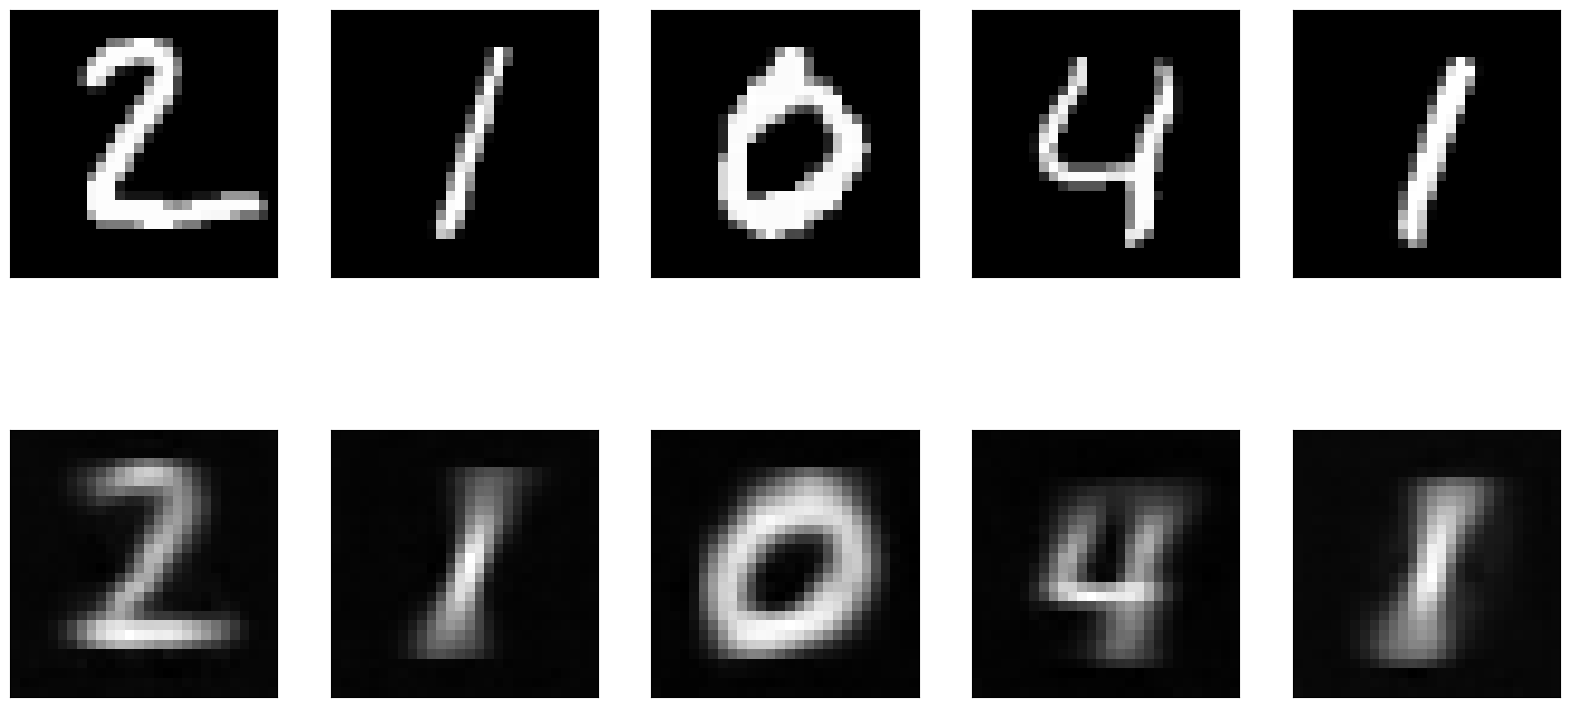

In [94]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(flutterCodes.predict(g_test[i:(i+1),:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


1/1 [==============================] - 0s 22ms/step


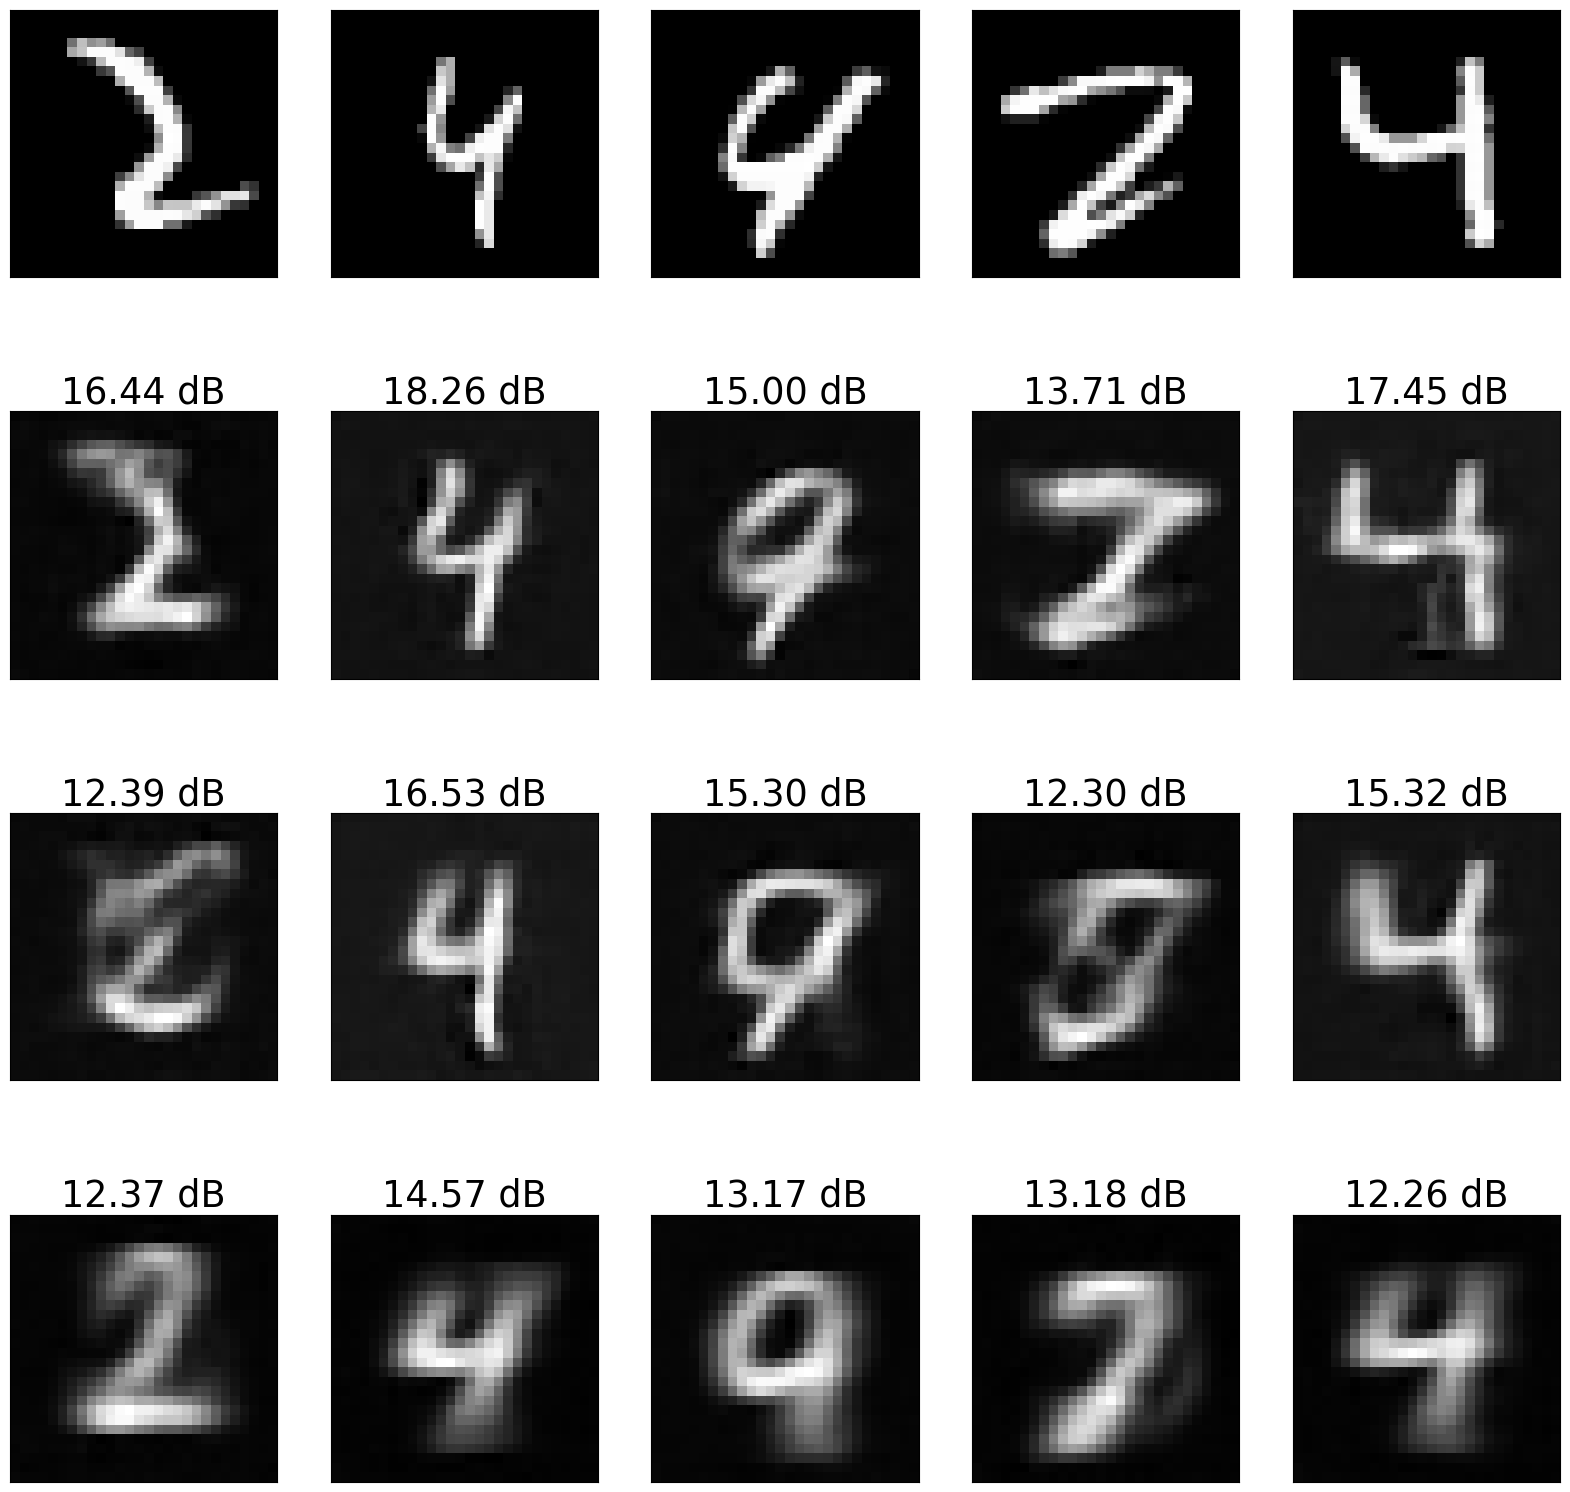

In [144]:
n = 5
plt.figure(figsize=(20, 20))
images=np.random.randint(1,1000,n+1)
#images=range(1,n+2)
for i in range(1, n +1):
    ax = plt.subplot(4, n, i)
    testImage=x_test[images[i]]
    plt.imshow(testImage)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, n+i)
    gt=np.reshape(np.matmul(H3,np.reshape(testImage,N**2)),(1,N))
    gt=gt/np.max(gt)
    plt.imshow(randomCodes.predict(gt)[0,:,:,0])
    plt.gray()
    plt.title('%.2f dB' %psnr(testImage,randomCodes.predict(gt)[0,:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, 2*n+i)
    gt=np.reshape(np.matmul(H2,np.reshape(testImage,N**2)),(1,N))
    gt=gt/np.max(gt)
    plt.imshow(cactiCodes.predict(gt)[0,:,:,0])
    plt.gray()
    plt.title('%.2f dB' %psnr(testImage,cactiCodes.predict(gt)[0,:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4, n, 3*n+i)
    gt=np.reshape(np.matmul(H1,np.reshape(testImage,N**2)),(1,N))
    gt=gt/np.max(gt)
    plt.imshow(flutterCodes.predict(gt)[0,:,:,0])
    plt.gray()
    plt.title('%.2f dB' %psnr(testImage,flutterCodes.predict(gt)[0,:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig('cactiRecon.pdf')

In [99]:
poop=np.reshape(gt,(1,N))